# Contrail detection

Using pre-trained model to detect contrail on a local dataset from OpenContrails

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import data
from contrail import ContrailModel

torch.set_grad_enabled(False)


c:\Users\anton\anaconda3\envs\resunet_env_V3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Displaying a model segmentation
Use pre-trained model. To do so, download the wanted pre-trained model in a local folder named *models* localised in the *data* folder from the link https://surfdrive.surf.nl/files/index.php/s/n1b0L2qfu2PZ6d3

In [2]:
path_to_model = "data/models/google_fewshot_1000-dice-30minute.torch" # Choose your model
model = ContrailModel("UNet", in_channels=1, out_classes=1)
model.load_state_dict(torch.load(path_to_model))

<All keys matched successfully>

Then load the data. Choose the number of images you want to load by specifying it in the variable *batch_size*

In [3]:
train_dataset, test_dataset = data.own_dataset(train=False)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=3,
    num_workers=0,
    shuffle=True,
)

batch = next(iter(test_dataloader))
images = batch[0]
masks = batch[1]

c:\Users\anton\OneDrive - ISAE-SUPAERO\Documents\MES DOC\SUPAERO\4A\PIE\Code\contrail-seg-main\data.py:80: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(


Then evaluate the model and compute its predictions

In [4]:
model.eval()
logits1 = model(batch[0])
pred1 = logits1.sigmoid()

Finally, plot the image, its mask and the prediction made by the model in order to compare visually

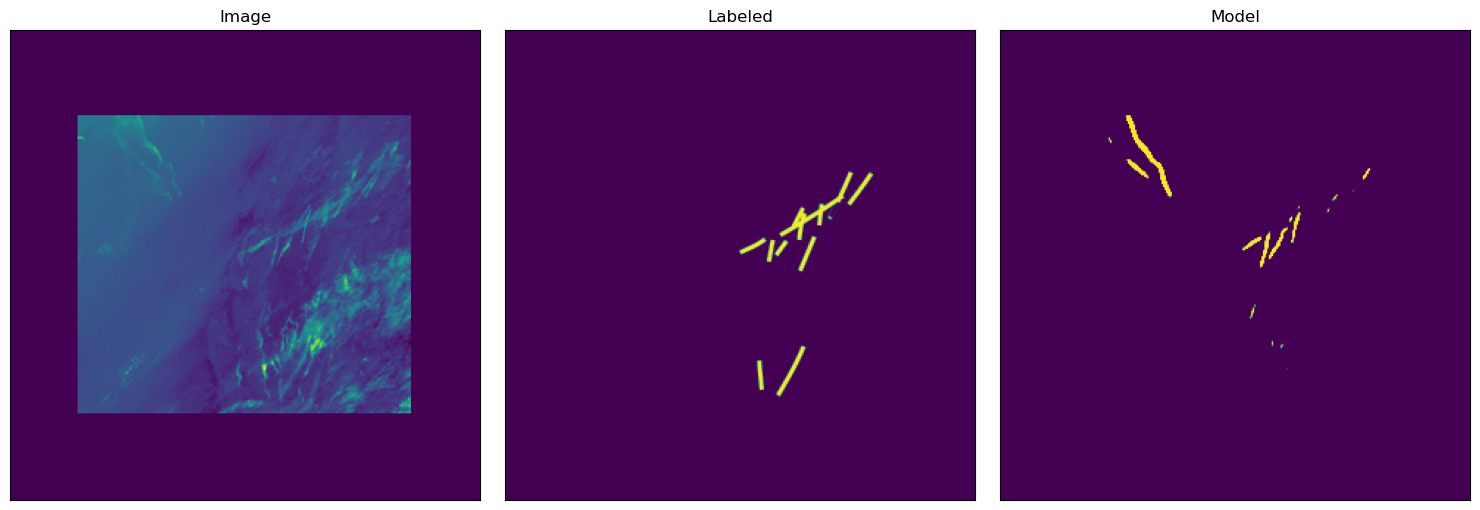

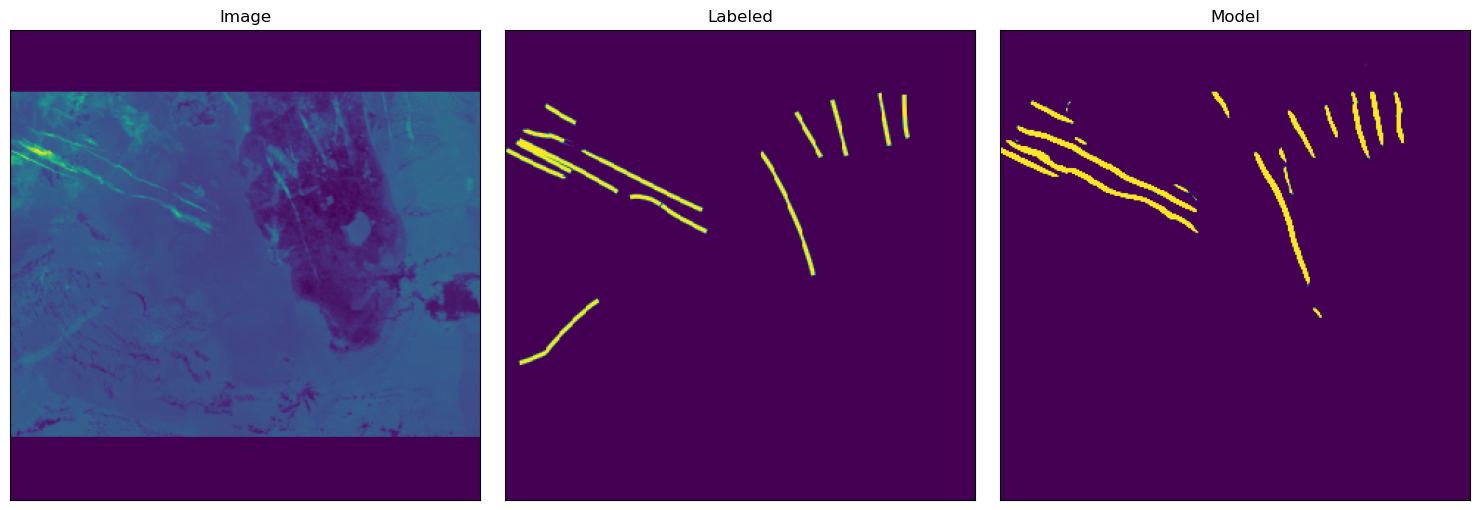

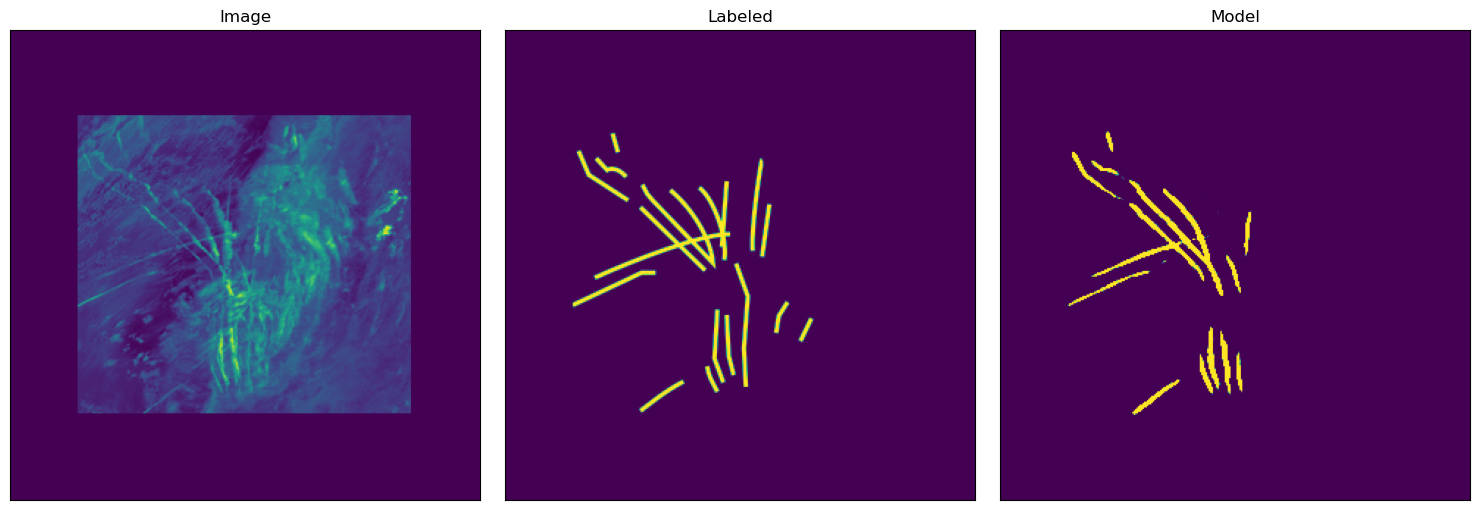

In [5]:
for i in range(len(batch[0])):
    image = batch[0][i]
    mask = batch[1][i]

    d = {
        "Image": np.array(image),
        "Labeled": np.array(mask),
        "model": np.array(pred1[i]),
    }

    data.visualize(**d)

### Infering the model
Now, the goal is to evaluate the perfomance of the model according to 2 types of per-pixel metrics: the F1 score and the AUC score.
A larger batch (1000 images) is used to infer the model in order to get a more reliable value. The inference is calculated on the whole batch.

In [6]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1000,
    num_workers=0,
    shuffle=True,
)

batch = next(iter(test_dataloader))

F1 score:

In [7]:
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    predict = logits.sigmoid()

    # Binarize predictions for F1 score calculation
    predict = (predict > 0.5).float()
    target = batch[1]

    # Calculate Precision and Recall
    true_positives = torch.sum(predict * target)
    predicted_positives = torch.sum(predict)
    actual_positives = torch.sum(target)
    precision = true_positives / (predicted_positives + 1e-8)
    recall = true_positives / (actual_positives + 1e-8)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
    print('F1 score:', "\t", round(f1_score.item(), 3))

F1 score: 	 0.582


AUC score (with the ROC curve):

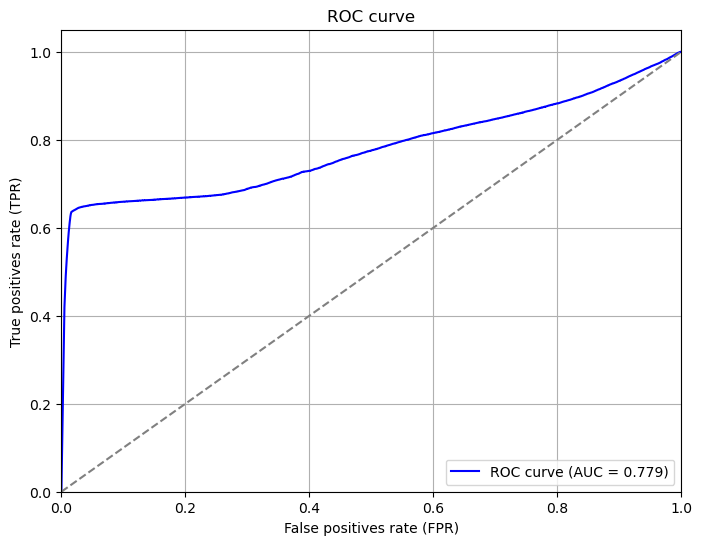

In [8]:
with torch.no_grad():
    logits = model(batch[0])
    probabilities = logits.sigmoid().cpu().numpy()

# Flatten 2D matrices into 1D arrays for pixel-wise ROC calculation
target_flatten = batch[1].cpu().numpy().flatten()
predict_flatten = probabilities.flatten()

# Binarize ground truth labels
target_flatten = (target_flatten > 0.5).astype(int)

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(target_flatten, predict_flatten)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with the AUC score (area under the curve)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positives rate (FPR)')
plt.ylabel('True positives rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()